<a href="https://colab.research.google.com/github/realfolkcode/convexity-graph-embeddings/blob/main/network_convexity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main functions

In [1]:
from __future__ import print_function
from IPython.display import clear_output
import torch
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
from time import time
import random
from random import choice
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from scipy.spatial import Delaunay
from copy import copy
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from google.colab import files
#from queue import Queue

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_hull_fw(G, FW, s):
    side = set(copy(s))
    new = {1}
    
    while len(new) != 0:
        new = set()
        for start, finish in list(combinations(side, 2)):
            for node in set(G.nodes()) - side:
                if FW[start, finish] > 1 and FW[start, node] + FW[node, finish] == FW[start, finish]:
                    new.add(node)
                    #print(node, start, finish)
        #print(new)
        side = side.union(new)
    return list(side)

In [3]:
G = nx.karate_club_graph()
A = nx.adjacency_matrix(G).todense()

FW = nx.floyd_warshall_numpy(G)
GFW = nx.convert_matrix.from_numpy_matrix(FW)

In [4]:
def in_hull_l1(p, simplex_min, simplex_max):
    K = len(simplex_min)
    for d in range(K):
        if (p[d] < simplex_min[d]) or (p[d] > simplex_max[d]):
            return False
    return True

In [5]:
def get_from_hull(emb, hull):
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    n = emb.shape[0]
    res = []
    for i in range(n):
        if hull.find_simplex(emb[i])>=0:
            res.append(i)
    return res

In [6]:
def get_from_hull_l1(emb, base):
    K = emb.shape[1]
    simplex_min = np.ones(K) * emb[base[0]]
    simplex_max = np.ones(K) * emb[base[0]]
    for d in range(K):
        for i in range(len(base)):
            if emb[base[i], d] < simplex_min[d]:
                simplex_min[d] = emb[base[i], d]
            if emb[base[i], d] > simplex_max[d]:
                simplex_max[d] = emb[base[i], d]

    res = []
    for i in range(emb.shape[0]):
        if in_hull_l1(emb[i], simplex_min, simplex_max):
            res.append(i)
    return res

In [7]:
def comparison_score(s1, s2):
    return len(set(s1).intersection(set(s2))) / len(set(s1).union(set(s2)))

In [8]:
def projection_score(h_graph, h_space):
    # h_graph and h_space need to be sorted!

    h_graph.sort()
    h_space.sort()
    s = len(h_space)
    err = 0
    s_itr = 0
    for g_itr in range(len(h_graph)):
        while s_itr < len(h_space) and h_space[s_itr] < h_graph[g_itr]:
            err += 1
            s_itr += 1
        s_itr += 1

    return (s - err) / s

In [9]:
def test_comparison_l1(emb, G, n_itr, n_base, log=True, debug=False):
    np.random.seed(42)
    FW = nx.floyd_warshall_numpy(G)
    mean_score = 0
    i = 0
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)
        h_graph = get_hull_fw(G, FW, base)
        h_space = get_from_hull_l1(emb, base)
        s = comparison_score(h_space, h_graph)
        if debug:
            print(base)
            print(h_space)
            print(h_graph)
        if log:
            print(s)
        mean_score += s
        i += 1
    mean_score /= n_itr
    return mean_score

In [10]:
def test_comparison_time(emb, G, n_itr, n_base, log=True):
    np.random.seed(42)
    mean_score = 0
    i = 0
    g_time = []
    s_time = []
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)

        try:
            s_start = time()
            h = Delaunay(emb[base].tolist())
            h_space = get_from_hull(emb, h)
            s_end = time()
            s_time.append(s_end - s_start)

            g_start = time()
            h_graph = get_hull_fw(G, FW, base)
            g_end = time()
            g_time.append(g_end - g_start)

            s = comparison_score(h_space, h_graph)
            if log:
                print(s)
            mean_score += s
            i += 1
        except:
            if log:
                print('Delaunay error')
    mean_score /= n_itr
    return mean_score, g_time, s_time

In [11]:
def test_comparison_l1_time(emb, G, n_itr, n_base, log=True, debug=False):
    np.random.seed(42)
    FW = nx.floyd_warshall_numpy(G)
    mean_score = 0
    i = 0
    g_time = []
    s_time = []
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)

        g_start = time()
        h_graph = get_hull_fw(G, FW, base)
        g_end = time()
        g_time.append(g_end - g_start)

        s_start = time()
        h_space = get_from_hull_l1(emb, base)
        s_end = time()
        s_time.append(s_end - s_start)

        s = comparison_score(h_space, h_graph)
        if debug:
            print(base)
            print(h_space)
            print(h_graph)
        if log:
            print(s)
        mean_score += s
        i += 1
    mean_score /= n_itr
    return mean_score, g_time, s_time

In [12]:
def test_projection_l1(emb, G, n_itr, n_base, log=True):
    np.random.seed(42)
    FW = nx.floyd_warshall_numpy(G)
    mean_score = 0
    i = 0
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)
        h_graph = get_hull_fw(G, FW, base)
        try:
            h_space = get_from_hull_l1(emb, h_graph)
            s = projection_score(h_graph, h_space)
            if log:
                print(s)
            mean_score += s
            i += 1
        except:
            if log:
                print('Delaunay error')
    mean_score /= n_itr
    return mean_score

In [13]:
def distdec_l1(u, v):
    return  torch.dist(u, v, p=1)

In [14]:
def distance_matrix_l1(emb):
    n = emb.shape[0]
    D = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            D[i, j] = np.linalg.norm(emb[i] - emb[j], ord=1)
    return D

# Graph Convolutional Networks

## Implementation

In [15]:
print(torch.__version__)

1.9.0+cu111


In [16]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install -q torch-geometric

     |████████████████████████████████| 10.4 MB 7.3 MB/s 
     |████████████████████████████████| 3.7 MB 7.4 MB/s 
     |████████████████████████████████| 308 kB 6.8 MB/s 
     |████████████████████████████████| 407 kB 46.5 MB/s 
     |████████████████████████████████| 45 kB 1.7 MB/s 


In [17]:
from torch_geometric.datasets import KarateClub
from torch.nn import Linear, ModuleList
from torch_geometric.nn import GCNConv
import torch_geometric

In [18]:
class GCN(torch.nn.Module):
    def __init__(self, h_sizes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv = ModuleList()
        self.conv.append(GCNConv(data.num_features, h_sizes[0]))
        for i in range(1, len(h_sizes)):
            self.conv.append(GCNConv(h_sizes[i-1], h_sizes[i]))

    def forward(self, x, edge_index):
        h = self.conv[0](x, edge_index)
        for i in range(1, len(self.conv)):
            h = h.relu()
            h = self.conv[i](h, edge_index)

        return h

In [19]:
def loss_euclidean(X, A, norm=1):
    dist = torch.cdist(X, X, p=norm)
    k = dist.shape[0]**2 - dist.shape[0]
    s = torch.sum((dist - A)**2) / k
    return s

In [20]:
def gcn_train(data):
    optimizer.zero_grad()
    emb = model(data.x, data.edge_index)
    loss = loss_euclidean(emb, torch.tensor(FW / np.max(FW)), norm=2)
    loss.backward()
    optimizer.step()
    return loss, emb

In [21]:
def gcn_train_l1(data):
    optimizer.zero_grad()
    emb = model(data.x, data.edge_index)
    loss = loss_euclidean(emb, torch.tensor(FW / np.max(FW)), norm=1)
    loss.backward()
    optimizer.step()
    return loss, emb

In [22]:
def custom_data(G):
    data = torch_geometric.utils.from_networkx(G)
    data.x = torch.eye(len(G))
    return data

In [23]:
def discretize(emb, decimals):
    return np.around(emb, decimals=decimals)

## Three layers

In [ ]:
data = custom_data(G)
FW = nx.floyd_warshall_numpy(G)

In [ ]:
model = GCN([21, 14, 7])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.2025, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.1411, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0872, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0559, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0446, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0387, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0356, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0337, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0322, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0309, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0298, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0289, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0282, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0276, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0272, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0267, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, G, 50, 4, log=False))

Comparison score: 0.3529060819529256


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, G, 50, 4, log=False))

Comparison score: 0.6083130206940275
Comparison score: 0.41763738882974316
Comparison score: 0.37154882517461607
Comparison score: 0.35905759710444074
Comparison score: 0.3529060819529256
Comparison score: 0.3529060819529256


In [ ]:
print('Projection score:', test_projection_l1(emb, G, 50, 4, log=False))

Projection score: 0.9713643149375413


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Projection score:', test_projection_l1(demb, G, 50, 4, log=False))

Projection score: 0.7944632947318101
Projection score: 0.9624071720803983
Projection score: 0.9713643149375413
Projection score: 0.9713643149375413
Projection score: 0.9713643149375413
Projection score: 0.9713643149375413


# Communities

## Implementation

In [24]:
import community as co

In [25]:
def labels_from_partition(part):
    labels = {}
    for i in range(len(part)):
        if part[i] not in labels:
            labels[part[i]] = [i]
        else:
            labels[part[i]].append(i)
    return labels

In [26]:
def graph_community(G, labels, community):
    SG = nx.subgraph(G, labels[community]).copy()
    idx = {}
    i = 0
    for v in SG.nodes():
        idx[v] = i
        i += 1
    SG = nx.relabel_nodes(SG, idx)
    return SG

In [27]:
def test_comparison_community(emb, G, n_itr, n_base, labels, ext=False, log=True, debug=False):
    np.random.seed(42)
    mean_score = 0
    i = 0
    while i < n_itr:
        if ext == False:
            community = np.random.randint(0, len(labels))
            base = np.random.choice(labels[community], n_base, replace=False)
        else:
            #n_base_0 = np.random.choice(np.arange(1, n_base))
            #n_base_1 = n_base - n_base_0
            #base = np.random.choice(labels[0], n_base_0, replace=False)
            #base = np.append(base, np.random.choice(labels[1], n_base_1, replace=False))
            base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)
        h_graph = get_hull_fw(G, FW, base)
        h_space = get_from_hull_l1(emb, base)
        s = comparison_score(h_space, h_graph)
        if debug:
            print(base)
            print(h_space)
            print(h_graph)
        if log:
            print(s)
        mean_score += s
        i += 1
    mean_score /= n_itr
    return mean_score

# Convex skeleton

## Implementation

In [28]:
def check_connectivity(G):
    return nx.is_connected(G)

In [29]:
# calculate the change in clustering when an edge gets removed

def change_in_clustering(G, a, b):
    c1 = nx.clustering(G, [a, b])
    G.remove_edge(a, b)
    c2 = nx.clustering(G, [a, b])
    G.add_edge(a, b)
    return c2[a] - c1[a] + c2[b] - c1[b]

In [30]:
def get_convex_skeleton(G, m):
    skeleton = G.copy()
    removed_edges = []
    candidates = list(G.edges())
    i = 0
    while i < m:
        max_edge_c = -100
        if not candidates:
            break
        for a, b in candidates:
            delta_c = change_in_clustering(skeleton, a, b)
            if delta_c > max_edge_c:
                target = (a, b)
                max_edge_c = delta_c
        skeleton.remove_edge(target[0], target[1])
        if check_connectivity(G):
            removed_edges.append((target[0], target[1]))
            print(i, (target[0], target[1]))
        else:
            skeleton.add_edge(target[0], target[1])
        candidates.remove((target[0], target[1]))
        i += 1
    return skeleton, removed_edges

In [31]:
def get_hull_fw_growth(G, FW, side):
    new = {1}
    outer = set(G.nodes()) - side
    
    while len(new) != 0:
        new = set()
        for start, finish in list(combinations(side, 2)):
            for node in outer:
                if FW[start, finish] > 1 and FW[start, node] + FW[node, finish] == FW[start, finish]:
                    new.add(node)
        side = side.union(new)
        outer = outer - new
    return side

In [32]:
def growth(G, FW):
    S = {np.random.choice(G.nodes())}
    sz = [1 / len(G)]
    while len(S) < nx.number_of_nodes(G):
        p = []
        for v in G.nodes():
            if v in S:
                tmp = 0
            else:
                tmp = len(set(G.neighbors(v)).intersection(S))
            p.append(tmp)
        p = np.array(p)
        norm = np.linalg.norm(p, ord=1)
        if norm > 0:
            p = p / norm
        new_node = np.random.choice(G.nodes(), p=p)
        S.add(new_node)
        S = get_hull_fw_growth(G, FW, S)
        sz.append(len(S) / len(G))
    return sz

In [33]:
def calculate_convexity(G, n_itr):
    lst = []
    max_size = 0
    FW = nx.floyd_warshall_numpy(G)
    for i in range(n_itr):
        tmp = growth(G, FW)
        lst.append(tmp)
        if len(tmp) > max_size:
            max_size = len(tmp)
        print(i)
    for i in range(n_itr):
        for _ in range(max_size - len(lst[i])):
            lst[i].append(1)
    avg_sz = []
    for i in range(max_size):
        s = 0
        for j in range(n_itr):
            s += lst[j][i]
        s /= n_itr
        avg_sz.append(s)
    X = 1
    for i in range(1, max_size):
        X -= max(0, avg_sz[i] - avg_sz[i-1] - 1 / len(G))
    return X

## Karate Club

In [ ]:
G = nx.karate_club_graph()
FW = nx.floyd_warshall_numpy(G)

In [ ]:
skeleton, removed_edges = get_convex_skeleton(G, 12)

0 (23, 25)
1 (24, 27)
2 (2, 27)
3 (2, 28)
4 (19, 33)
5 (4, 10)
6 (1, 30)
7 (13, 33)
8 (0, 8)
9 (2, 8)
10 (2, 32)
11 (2, 9)


In [ ]:
print('Average clustering:', np.mean(list(nx.clustering(G).values())))
print('Average clustering (skeleton):', np.mean(list(nx.clustering(skeleton).values())))

Average clustering: 0.5706384782076823
Average clustering (skeleton): 0.7659409218232748


In [ ]:
print('Average degree:', np.mean([d for node, d in nx.degree(G)]))
print('Average degree:', np.mean([d for node, d in nx.degree(skeleton)]))

Average degree: 4.588235294117647
Average degree: 3.8823529411764706


In [ ]:
g = []
for i, j in list(combinations(range(34), 2)):
    s = 0
    for p in nx.all_shortest_paths(G, i, j):
        s += 1
    g.append(s)
print('Average number of geodesics:', np.mean(g))

Average number of geodesics: 2.7736185383244205


In [ ]:
g = []
for i, j in list(combinations(range(34), 2)):
    s = 0
    for p in nx.all_shortest_paths(skeleton, i, j):
        s += 1
    g.append(s)
print('Average number of geodesics (skeleton):', np.mean(g))

Average number of geodesics (skeleton): 1.4848484848484849


In [ ]:
calculate_convexity(G, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.5758823529411776

In [ ]:
calculate_convexity(skeleton, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.901470588235295

In [ ]:
edge_color = []
for i, j in G.edges():
    if (i, j) in removed_edges:
        edge_color.append('red')
    else:
        edge_color.append('black')

In [ ]:
current_edges = []
for i, j in G.edges():
    if (i, j) not in removed_edges:
        current_edges.append((i, j))

In [ ]:
pos = nx.spring_layout(G, seed=42)

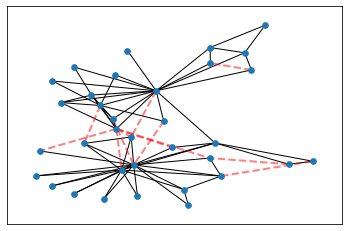

In [ ]:
nx.draw_networkx_nodes(G, pos=pos, node_size=32)
nx.draw_networkx_edges(G, pos=pos, edgelist=current_edges, style='solid')
nx.draw_networkx_edges(G, pos=pos, edgelist=removed_edges, style='dashed', width=2., edge_color='red', alpha=0.5)
plt.savefig("Figure2.svg")

In [ ]:
data = custom_data(skeleton)
FW = nx.floyd_warshall_numpy(skeleton)

In [ ]:
model = GCN([21, 14, 7])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.2658, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.1883, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.1198, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0752, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0647, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0547, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0491, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0455, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0435, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0420, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0408, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0399, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0390, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0381, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0372, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0364, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, skeleton, 50, 4, log=False))

Comparison score: 0.7101327561327565


In [ ]:
print('Projection score:', test_projection_l1(emb, skeleton, 50, 4, log=False))

Projection score: 0.9826580086580085


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, skeleton, 50, 4, log=False))

Comparison score: 0.7008091630591632
Comparison score: 0.7439725829725832
Comparison score: 0.7076010101010104
Comparison score: 0.6978787878787882
Comparison score: 0.695656565656566
Comparison score: 0.695656565656566


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Projection score:', test_projection_l1(demb, skeleton, 50, 4, log=False))

Projection score: 0.7081150793650793
Projection score: 0.9528715728715725
Projection score: 0.9628802308802306
Projection score: 0.9628802308802306
Projection score: 0.9628802308802306
Projection score: 0.9628802308802306


# Convexity structure

In [ ]:
G = nx.karate_club_graph()
FW = nx.floyd_warshall_numpy(G)

In [ ]:
h = get_hull_fw(G, FW, [0, 33])
h

[0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33]

In [ ]:
c = 0
for i, j in list(combinations(h, 2)):
    t = get_hull_fw(G, FW, [i, j])
    if t==h:
        c += 1
    print(i, j, t, FW[i, j])
print(c)

0 1 [0, 1] 1.0
0 2 [0, 2] 1.0
0 8 [0, 8] 1.0
0 9 [0, 9, 2] 2.0
0 13 [0, 13] 1.0
0 19 [0, 19] 1.0
0 23 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 24 [0, 24, 31] 2.0
0 25 [0, 25, 31] 2.0
0 27 [0, 2, 27] 2.0
0 28 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 30 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 31 [0, 31] 1.0
0 32 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 33 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
1 2 [1, 2] 1.0
1 8 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
1 9 [1, 2, 9] 2.0
1 13 [1, 13] 1.0
1 19 [1, 19] 1.0
1 23 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
1 24 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
1 25 [0, 1, 25, 31] 3.0
1 27 [1, 2, 27] 2.0
1 28 [1, 2, 28] 2.0
1 30 [1, 30] 1.0
1 31 [0, 1, 31] 2.0
1 32 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
1 33 [0, 1, 2, 8, 9, 13, 19, 23, 24,

In [ ]:
relation = nx.Graph()
for i, j in list(combinations(h, 2)):
    t = get_hull_fw(G, FW, [i, j])
    if t==h:
        relation.add_edge(i, j)

In [ ]:
for i in G.nodes():
    if i not in h:
        relation.add_node(i)

In [ ]:
complement = nx.Graph()
for i, j in list(combinations(h, 2)):
    if (i, j) in G.edges():
        complement.add_edge(i, j)
for i in G.nodes():
    if i not in h:
        complement.add_node(i)

In [ ]:
for i in G.nodes():
    if i in h:
        print(complement.degree()[i], relation.degree()[i])

6 5
5 5
8 5
5 9
2 7
4 10
3 6
4 3
3 6
3 5
4 5
3 6
4 5
6 4
6 6
10 3


In [ ]:
pos = nx.spring_layout(G, seed=42)

In [ ]:
cmap=[]
for i in relation.nodes():
    if i in h:
        cmap.append('orange')
    else:
        cmap.append('#1f78b4')

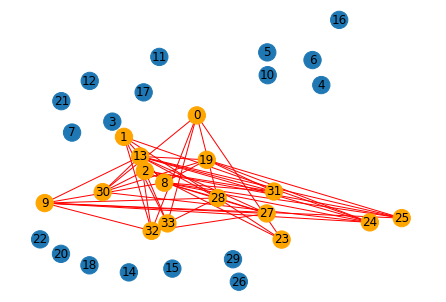

In [ ]:
nx.draw(relation, with_labels=True, pos=pos, node_color=cmap, edge_color='red')
plt.savefig("Figure9A.svg")

In [ ]:
cmap=[]
for i in G.nodes():
    if i in h:
        cmap.append('orange')
    else:
        cmap.append('#1f78b4')

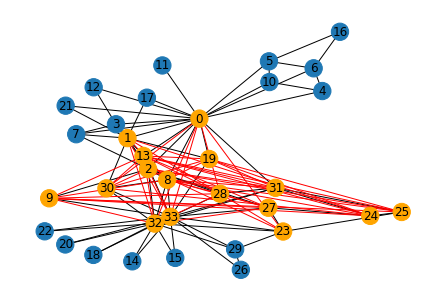

In [ ]:
nx.draw(G, with_labels=True, pos=pos, node_color=cmap)
nx.draw_networkx_edges(relation, pos=pos, edge_color='red')
plt.savefig("Figure9B.svg")

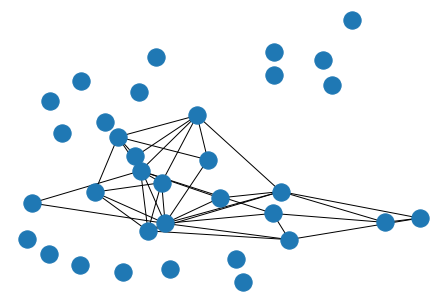

In [ ]:
nx.draw(complement, pos=pos)

In [ ]:
nx.number_of_edges(relation)

45

In [ ]:
s = 0
pairs = 0
for i, j in list(combinations(range(34), 2)):
    if not G.has_edge(i, j):
      t = get_hull_fw(G, FW, [i, j])
      s += len(t)
      pairs += 1
      print(i, j, t, FW[i, j])
s = s / pairs
print('Average convex hull size:', s)

0 9 [0, 9, 2] 2.0
0 14 [0, 1, 2, 8, 9, 13, 14, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 15 [0, 1, 2, 8, 9, 13, 15, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 16 [0, 16, 5, 6] 2.0
0 18 [0, 1, 2, 8, 9, 13, 18, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 20 [0, 1, 2, 8, 9, 13, 19, 20, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 22 [0, 1, 2, 8, 9, 13, 19, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 23 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 24 [0, 24, 31] 2.0
0 25 [0, 25, 31] 2.0
0 26 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] 3.0
0 27 [0, 2, 27] 2.0
0 28 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 29 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33] 3.0
0 30 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 32 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 33 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
1 4 [0, 1, 4] 2.0
1 5 [0, 1, 5] 2.0
1

In [ ]:
skeleton, removed_edges = get_convex_skeleton(G, 12)

0 (23, 25)
1 (24, 27)
2 (2, 27)
3 (2, 28)
4 (19, 33)
5 (4, 10)
6 (1, 30)
7 (13, 33)
8 (0, 8)
9 (2, 8)
10 (2, 32)
11 (2, 9)


In [ ]:
s = 0
pairs = 0
FW = nx.floyd_warshall_numpy(skeleton)
for i, j in list(combinations(range(34), 2)):
    if not skeleton.has_edge(i, j):
        t = get_hull_fw(skeleton, FW, [i, j])
        s += len(t)
        pairs += 1
        print(i, j, t, FW[i, j])
s = s / pairs
print('Average convex hull size:', s)

0 8 [0, 32, 33, 8, 31] 3.0
0 9 [0, 9, 31, 33] 3.0
0 14 [0, 32, 33, 14, 31] 3.0
0 15 [0, 32, 33, 31, 15] 3.0
0 16 [0, 16, 5, 6] 2.0
0 18 [0, 32, 18, 33, 31] 3.0
0 20 [0, 32, 33, 20, 31] 3.0
0 22 [0, 32, 33, 22, 31] 3.0
0 23 [0, 32, 33, 23, 31] 3.0
0 24 [0, 24, 31] 2.0
0 25 [0, 25, 31] 2.0
0 26 [0, 33, 26, 31] 3.0
0 27 [0, 33, 27, 31] 3.0
0 28 [0, 28, 31] 2.0
0 29 [0, 32, 33, 29, 31] 3.0
0 30 [0, 32, 33, 30, 31] 3.0
0 32 [0, 32, 31] 2.0
0 33 [0, 33, 31] 2.0
1 4 [0, 1, 4] 2.0
1 5 [0, 1, 5] 2.0
1 6 [0, 1, 6] 2.0
1 8 [0, 1, 33, 32, 8, 31] 4.0
1 9 [0, 1, 33, 9, 31] 4.0
1 10 [0, 1, 10] 2.0
1 11 [0, 1, 11] 2.0
1 12 [0, 1, 3, 12] 2.0
1 14 [0, 1, 33, 32, 14, 31] 4.0
1 15 [0, 1, 33, 32, 31, 15] 4.0
1 16 [16, 1, 0, 5, 6] 3.0
1 18 [0, 1, 18, 33, 32, 31] 4.0
1 20 [0, 1, 33, 32, 20, 31] 4.0
1 22 [0, 1, 33, 32, 22, 31] 4.0
1 23 [0, 1, 33, 32, 23, 31] 4.0
1 24 [24, 1, 0, 31] 3.0
1 25 [0, 1, 25, 31] 3.0
1 26 [0, 1, 33, 26, 31] 4.0
1 27 [0, 1, 33, 27, 31] 4.0
1 28 [0, 1, 28, 31] 3.0
1 29 [0, 1, 33, 32, 2

# Time comparison

## Implementation

In [34]:
def test_comparison_time(emb, G, n_itr, n_base, log=True):
    np.random.seed(42)
    mean_score = 0
    i = 0
    g_time = []
    s_time = []
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)

        try:
            s_start = time()
            h = Delaunay(emb[base].tolist())
            h_space = get_from_hull(emb, h)
            s_end = time()
            s_time.append(s_end - s_start)

            g_start = time()
            h_graph = get_hull_fw(G, FW, base)
            g_end = time()
            g_time.append(g_end - g_start)

            s = comparison_score(h_space, h_graph)
            if log:
                print(s)
            mean_score += s
            i += 1
        except:
            if log:
                print('Delaunay error')
    mean_score /= n_itr
    return mean_score, g_time, s_time

In [35]:
def test_comparison_lp_time(emb, G, n_itr, n_base, method='interior-point', log=True):
    np.random.seed(42)
    mean_score = 0
    i = 0
    g_time = []
    s_time = []
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)

        try:
            s_start = time()
            h_space = get_from_hull_lp(emb, base, method=method)
            s_end = time()
            s_time.append(s_end - s_start)

            g_start = time()
            h_graph = get_hull_fw(G, FW, base)
            g_end = time()
            g_time.append(g_end - g_start)

            s = comparison_score(h_space, h_graph)
            if log:
                print(s)
            mean_score += s
            i += 1
        except:
            if log:
                print('Hull error')
    mean_score /= n_itr
    return mean_score, g_time, s_time

In [36]:
def test_comparison_l1_time(emb, G, n_itr, n_base, log=True, debug=False):
    np.random.seed(42)
    FW = nx.floyd_warshall_numpy(G)
    mean_score = 0
    i = 0
    g_time = []
    s_time = []
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)

        g_start = time()
        h_graph = get_hull_fw(G, FW, base)
        g_end = time()
        g_time.append(g_end - g_start)

        s_start = time()
        h_space = get_from_hull_l1(emb, base)
        s_end = time()
        s_time.append(s_end - s_start)

        s = comparison_score(h_space, h_graph)
        if debug:
            print(base)
            print(h_space)
            print(h_graph)
        if log:
            print(s)
        mean_score += s
        i += 1
    mean_score /= n_itr
    return mean_score, g_time, s_time

In [37]:
def naive_implementation(G, s):
    newfound = copy(set(s))
    temp = {1}  # whatever
    
    while len(temp) != 0:
        temp = set()
        for start, finish in list(combinations(newfound, 2)):  # remake to pairs (first set, second set)
            for path in list(nx.all_shortest_paths(G, start, finish)):
                for elem in path[1:-1]:
                    if elem not in temp and elem not in newfound:
                        temp.add(elem)
        newfound = newfound.union(temp)

    return list(newfound)

## Random graph generation

In [ ]:
np.random.seed(42)
random.seed(42)

rg50 = nx.generators.random_graphs.erdos_renyi_graph(50, 0.1)
fw50 = nx.floyd_warshall_numpy(rg50)
nx.write_edgelist(rg50, "rg50.txt", data=False)

rg100 = nx.generators.random_graphs.erdos_renyi_graph(100, 0.1)
fw100 = nx.floyd_warshall_numpy(rg100)
nx.write_edgelist(rg100, "rg100.txt", data=False)

rg150 = nx.generators.random_graphs.erdos_renyi_graph(150, 0.1)
fw150 = nx.floyd_warshall_numpy(rg150)
nx.write_edgelist(rg150, "rg150.txt", data=False)

rg200 = nx.generators.random_graphs.erdos_renyi_graph(200, 0.1)
fw200 = nx.floyd_warshall_numpy(rg200)
nx.write_edgelist(rg200, "rg200.txt", data=False)

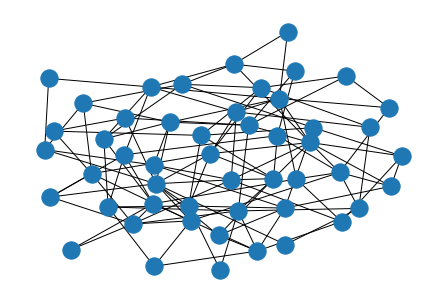

In [ ]:
nx.draw(rg50, pos=nx.kamada_kawai_layout(rg50))

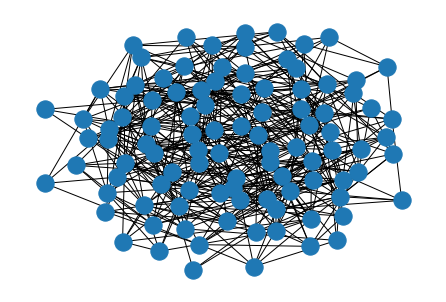

In [ ]:
nx.draw(rg100, pos=nx.kamada_kawai_layout(rg100))

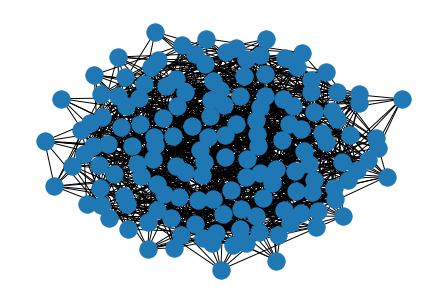

In [ ]:
nx.draw(rg150, pos=nx.kamada_kawai_layout(rg150))

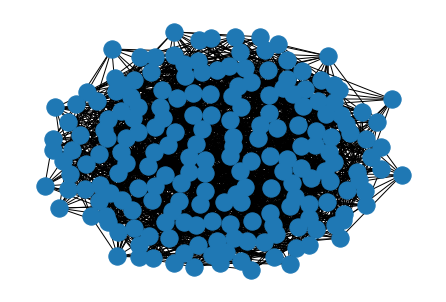

In [ ]:
nx.draw(rg200, pos=nx.kamada_kawai_layout(rg200))

## Load generated graphs

In [ ]:
files.upload()

In [ ]:
rg50 = nx.read_edgelist("/content/rg50.txt", nodetype=int, data=False)
fw50 = nx.floyd_warshall_numpy(rg50)
rg100 = nx.read_edgelist("/content/rg100.txt", nodetype=int, data=False)
fw100 = nx.floyd_warshall_numpy(rg100)
rg150 = nx.read_edgelist("/content/rg150.txt", nodetype=int, data=False)
fw150 = nx.floyd_warshall_numpy(rg150)
rg200 = nx.read_edgelist("/content/rg200.txt", nodetype=int, data=False)
fw200 = nx.floyd_warshall_numpy(rg200)

## Base 2

[24, 1]
[32, 30]
[34, 26]
[16, 15]
[23, 42]
[15, 27]
[5, 19]
[0, 40]
[5, 26]
[40, 14]
[28, 8]
[86, 24]
[80, 18]
[0, 94]
[16, 39]
[38, 49]
[80, 42]
[23, 61]
[78, 93]
[69, 31]
[117, 132]
[74, 94]
[32, 119]
[73, 100]
[35, 91]
[70, 116]
[149, 73]
[26, 24]
[48, 102]
[52, 92]
[57, 195]
[48, 117]
[155, 77]
[168, 167]
[68, 53]
[83, 107]
[48, 149]
[26, 6]
[152, 136]
[129, 140]


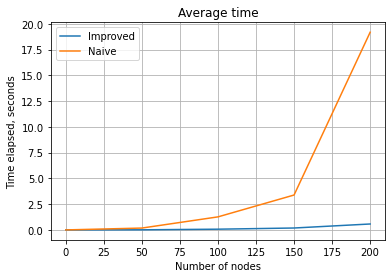

In [ ]:
fws = [fw50, fw100, fw150, fw200]
graphs = [rg50, rg100, rg150, rg200]

ourans = []
naiveans = []
for i in range(len(graphs)):
    bases = [list(np.random.choice(graphs[i].nodes(), 2, replace=False)) for _ in range(10)]

    ourtimes = []
    naivetimes = []
    for base in bases:
        print(base)
        t = time()
        ss = get_hull_fw(graphs[i], fws[i], base)
        ourtimes.append(time() - t)
        t = time()
        ss = naive_implementation(graphs[i], base)
        naivetimes.append(time() - t)
        #clear_output(True)
    ourans.append(ourtimes)
    naiveans.append(naivetimes)

f, ax = plt.subplots()
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in ourans], label='Improved')
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in naiveans], label='Naive')
ax.set_title('Average time')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Time elapsed, seconds')
ax.grid()
ax.legend()
plt.savefig("Figure 5 - Left.svg")
plt.show()

## Base 3

[4, 45, 13]
[41, 48, 0]
[32, 0, 8]
[49, 17, 9]
[16, 11, 34]
[32, 30, 26]
[0, 19, 48]
[37, 31, 29]
[13, 9, 10]
[18, 20, 10]
[6, 35, 43]
[23, 50, 82]
[32, 95, 84]
[0, 88, 98]
[54, 45, 85]
[59, 95, 76]
[73, 99, 1]
[62, 33, 87]
[82, 73, 81]
[73, 72, 15]
[18, 111, 120]
[149, 89, 103]
[116, 11, 77]
[31, 69, 77]
[85, 29, 70]
[33, 68, 141]
[128, 4, 139]
[60, 2, 132]
[59, 34, 88]
[105, 89, 77]
[157, 17, 40]
[67, 17, 119]
[136, 14, 199]
[54, 14, 122]
[25, 9, 75]
[102, 158, 28]
[80, 42, 189]
[71, 94, 42]
[66, 147, 7]
[52, 83, 4]


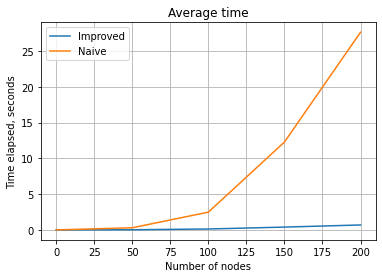

In [ ]:
fws = [fw50, fw100, fw150, fw200]
graphs = [rg50, rg100, rg150, rg200]

ourans = []
naiveans = []
for i in range(len(graphs)):
    bases = [list(np.random.choice(graphs[i].nodes(), 3, replace=False)) for _ in range(10)]

    ourtimes = []
    naivetimes = []
    for base in bases:
        print(base)
        t = time()
        ss = get_hull_fw(graphs[i], fws[i], base)
        ourtimes.append(time() - t)
        t = time()
        ss = naive_implementation(graphs[i], base)
        naivetimes.append(time() - t)
        #clear_output(True)
    ourans.append(ourtimes)
    naiveans.append(naivetimes)

f, ax = plt.subplots()
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in ourans], label='Improved')
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in naiveans], label='Naive')
ax.set_title('Average time')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Time elapsed, seconds')
ax.grid()
ax.legend()
plt.savefig("Figure 5 - Center.svg")
plt.show()

## Base 4

[23, 2, 44, 40]
[40, 23, 14, 24]
[8, 29, 22, 1]
[17, 20, 40, 23]
[0, 24, 16, 45]
[8, 36, 25, 10]
[19, 1, 26, 7]
[49, 22, 18, 15]
[20, 4, 39, 13]
[27, 17, 12, 42]
[28, 4, 25, 79]
[68, 59, 86, 87]
[21, 35, 34, 80]
[89, 70, 93, 54]
[22, 82, 26, 53]
[16, 82, 48, 90]
[72, 66, 2, 86]
[82, 95, 48, 22]
[76, 42, 74, 80]
[25, 27, 69, 58]
[131, 98, 62, 149]
[29, 142, 24, 130]
[129, 26, 133, 52]
[21, 115, 58, 62]
[58, 123, 69, 102]
[11, 131, 23, 25]
[31, 74, 116, 121]
[104, 109, 78, 89]
[20, 36, 39, 148]
[96, 130, 3, 93]
[164, 144, 80, 12]
[78, 160, 38, 101]
[26, 121, 81, 83]
[75, 101, 62, 110]
[46, 21, 93, 117]
[97, 127, 31, 65]
[9, 46, 164, 127]
[194, 109, 81, 53]
[95, 180, 113, 104]
[147, 112, 11, 19]


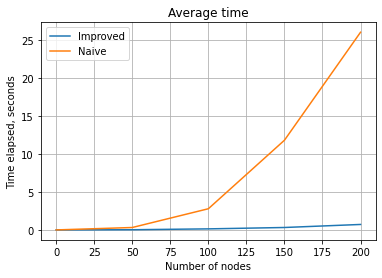

In [ ]:
fws = [fw50, fw100, fw150, fw200]
graphs = [rg50, rg100, rg150, rg200]

ourans = []
naiveans = []
for i in range(len(graphs)):
    bases = [list(np.random.choice(graphs[i].nodes(), 4, replace=False)) for _ in range(10)]

    ourtimes = []
    naivetimes = []
    for base in bases:
        print(base)
        t = time()
        ss = get_hull_fw(graphs[i], fws[i], base)
        ourtimes.append(time() - t)
        t = time()
        ss = naive_implementation(graphs[i], base)
        naivetimes.append(time() - t)
        #clear_output(True)
    ourans.append(ourtimes)
    naiveans.append(naivetimes)

f, ax = plt.subplots()
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in ourans], label='Improved')
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in naiveans], label='Naive')
ax.set_title('Average time')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Time elapsed, seconds')
ax.grid()
ax.legend()
plt.savefig("Figure 5 - Right.svg")
plt.show()

## Enron email network

In [ ]:
files.upload()

In [ ]:
G = nx.read_edgelist("/content/email-enron-only.mtx", nodetype=int, data=False)

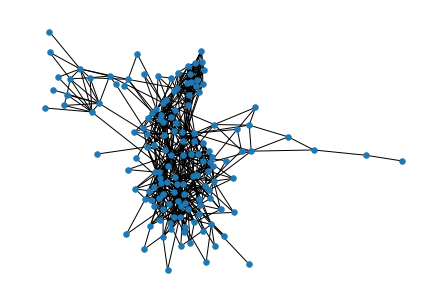

In [ ]:
nx.draw(G, node_size=30)

In [ ]:
nx.number_of_nodes(G)

143

In [ ]:
nx.number_of_edges(G)

623

In [ ]:
nx.diameter(G)

8

In [ ]:
mapping = {}
for i in G.nodes():
    mapping[i] = i - 1

In [ ]:
nx.relabel_nodes(G, mapping, copy=False)

In [ ]:
data = custom_data(G)
FW = nx.floyd_warshall_numpy(G)

In [ ]:
model = GCN([25, 20, 15])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.0880, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0328, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0216, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0165, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0148, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0135, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0124, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0116, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0110, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0105, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0100, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0095, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0092, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0089, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0086, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0084, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
g_bar = np.empty((2, 25))
l1_bar = np.empty((2, 25))
scores = []
for base in range(4, 29):
    score, g_time, s_time = test_comparison_l1_time(emb, G, 10, base, log=False)
    g_bar[0, base - 4] = np.mean(g_time)
    g_bar[1, base - 4] = np.std(g_time)
    scores.append(score)
    l1_bar[0, base - 4] = np.mean(s_time)
    l1_bar[1, base - 4] = np.std(s_time)

In [ ]:
print('Mean:', np.mean(scores))
print('Std:', np.std(scores))

Mean: 0.33005473005903724
Std: 0.17175323251443794


In [ ]:
model = GCN([10, 6, 3])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5000):
    loss, emb = gcn_train(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.1342, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.1145, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0931, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0718, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0542, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0431, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0381, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0355, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0332, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0311, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0296, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0284, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0276, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0270, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0264, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0259, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
l2_bar = np.empty((2, 25))
scores = []
for base in range(4, 29):
    score, g_time, s_time = test_comparison_time(emb, G, 10, base, log=False)
    scores.append(score)
    l2_bar[0, base - 4] = np.mean(s_time)
    l2_bar[1, base - 4] = np.std(s_time)

In [ ]:
print('Mean:', np.mean(scores))
print('Std:', np.std(scores))

Mean: 0.4087249547313619
Std: 0.18370389351833158


In [ ]:
model = GCN([25, 20, 15])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5000):
    loss, emb = gcn_train(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.1315, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0999, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0631, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0344, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0255, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0214, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0181, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0169, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0159, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0151, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0144, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0138, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0132, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0127, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0123, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0119, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
l2_15_bar = np.empty((2, 13))
scores = []
for base in range(16, 29):
    score, g_time, s_time = test_comparison_time(emb, G, 10, base, log=False)
    scores.append(score)
    l2_15_bar[0, base - 16] = np.mean(s_time)
    l2_15_bar[1, base - 16] = np.std(s_time)

In [ ]:
print('Mean:', np.mean(scores))
print('Std:', np.std(scores))

Mean: 0.12388651368544812
Std: 0.033404128163106485


In [ ]:
model = GCN([10, 6, 3])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.1245, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0971, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0702, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0495, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0401, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0366, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0332, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0309, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0296, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0288, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0282, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0276, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0268, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0261, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0254, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0248, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
l1_3_bar = np.empty((2, 25))
scores = []
for base in range(4, 29):
    score, g_time, s_time = test_comparison_l1_time(emb, G, 10, base, log=False)
    scores.append(score)
    l1_3_bar[0, base - 4] = np.mean(s_time)
    l1_3_bar[1, base - 4] = np.std(s_time)

In [ ]:
print('Mean:', np.mean(scores))
print('Std:', np.std(scores))

Mean: 0.6754852612014821
Std: 0.1719181530902585


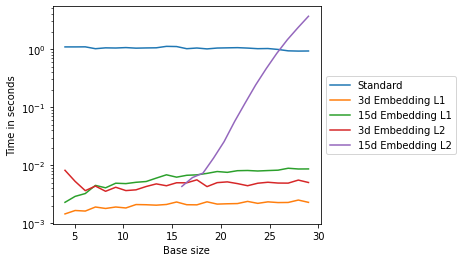

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.linspace(4, 29, 25), g_bar[0, :], label='Standard')
ax.plot(np.linspace(4, 29, 25), l1_3_bar[0, :], label='3d Embedding L1')
ax.plot(np.linspace(4, 29, 25), l1_bar[0, :], label='15d Embedding L1')
ax.plot(np.linspace(4, 29, 25), l2_bar[0, :], label='3d Embedding L2')
ax.plot(np.linspace(16, 29, 13), l2_15_bar[0, :], label='15d Embedding L2')
plt.yscale("log")
plt.xlabel('Base size')
plt.ylabel('Time in seconds')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1., 0.5))
fig.savefig("Figure6 right.svg", bbox_inches='tight')
fig.show()

# Additional figures

In [38]:
def plot_tri(ax, points, tri):
    edges = collect_edges(points, tri)
    x = np.array([])
    y = np.array([])
    z = np.array([])
    for (i,j) in edges:
        x = np.append(x, [points[i, 0], points[j, 0], np.nan])      
        y = np.append(y, [points[i, 1], points[j, 1], np.nan])      
        z = np.append(z, [points[i, 2], points[j, 2], np.nan])
    ax.plot3D(x, y, z, color='r', lw='0.5')

    ax.scatter(points[:,0], points[:,1], points[:,2], c=color_map)


def find_indices(points, tri_points):
    idx = []
    for x, y, z in tri_points:
        for i in range(len(points)):
            if points[i][0] == x and points[i][1] == y and points[i][2] == z:
                idx.append(i)
    return idx


def collect_edges(points, tri):
    edges = set()

    def sorted_tuple(a,b):
        return (a,b) if a < b else (b,a)
    # Add edges of tetrahedron (sorted so we don't add an edge twice, even if it comes in reverse order).
    for (i0, i1, i2, i3) in tri.simplices:
        idx = find_indices(points, tri.points[[i0, i1, i2, i3]])
        j0, j1, j2, j3 = idx
        edges.add(sorted_tuple(j0,j1))
        edges.add(sorted_tuple(j0,j2))
        edges.add(sorted_tuple(j0,j3))
        edges.add(sorted_tuple(j1,j2))
        edges.add(sorted_tuple(j1,j3))
        edges.add(sorted_tuple(j2,j3))
    return edges

In [39]:
data = custom_data(G)
FW = nx.floyd_warshall_numpy(G)
model = GCN([8, 4, 2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
#torch.manual_seed(42)
#np.random.seed(42)
for epoch in range(10000):
    loss, emb = gcn_train(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.2297, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.2113, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.1935, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.1751, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.1544, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.1315, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.1094, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0889, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0719, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0602, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0538, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0509, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0494, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0483, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0474, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0465, dtype=torch.float64, grad_fn=<Di

In [41]:
emb = emb.detach().numpy()

In [88]:
base = np.random.choice(np.arange(34), 4, replace=False)
base = [5, 14, 23, 25]
h_space = Delaunay(emb[base].tolist())
h_graph = get_hull_fw(G, FW, base)

In [89]:
base

[5, 14, 23, 25]

In [90]:
h_graph

[0, 1, 2, 5, 8, 9, 13, 14, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33]

In [91]:
color_map = []
for node in G:
    if node in base:
        color_map.append('red')
    elif node in h_graph:
        color_map.append('orange')
    else:
        color_map.append('blue')

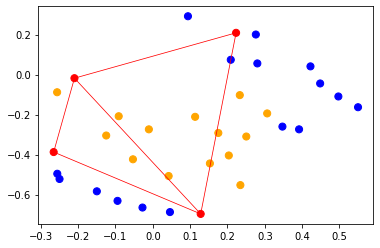

In [92]:
plt.triplot(h_space.points[:,0], h_space.points[:,1], h_space.simplices, c='r', linewidth=0.75)
plt.scatter(emb[:,0], emb[:,1], c=color_map, s=50)
plt.savefig('Figure7A.svg')

In [93]:
h_proj = Delaunay(emb[h_graph].tolist())

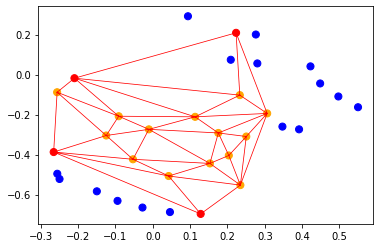

In [94]:
plt.triplot(h_proj.points[:,0], h_proj.points[:,1], h_proj.simplices, c='r', linewidth=0.75)
plt.scatter(emb[:,0], emb[:,1], c=color_map, s=50)
plt.savefig('Figure7B.svg')